In [15]:
import os 
import sys

'''
Create directory of dataset:
- efs_dir: mount point of efs
- dataset_dir: name of a directory to store dataset
'''
efs_dir = "/home/ec2-user/SageMaker/efs"
dataset_dir = "food101"
if not os.path.exists(efs_dir):
    print("Mount EFS on notebook instance. Food-101 dataset is very large.")
    sys.exit()
elif not os.path.exists(os.path.join(efs_dir, dataset_dir)):
    print("Creating dataset directory {}".format(os.path.join(efs_dir, dataset_dir)))
    os.mkdir(os.path.join(efs_dir, dataset_dir))
    
'''
Download dataset (This takes 20-30 minutes.)
'''
import urllib.request
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
urllib.request.urlretrieve(url, os.path.join(efs_dir, dataset_dir, 'food-101.tar.gz'))

('/home/ec2-user/SageMaker/efs/food101/food-101.tar.gz',
 <http.client.HTTPMessage at 0x7f5ad412d128>)

In [ ]:
import tarfile
file_name =  os.path.join(efs_dir, dataset_dir, 'food-101.tar.gz')
tar = tarfile.open(file_name, "r:gz")
tar.extractall(path=os.path.join(efs_dir, dataset_dir))
tar.close()

In [1]:
import os
efs_dir = "/home/ec2-user/SageMaker/efs"
dataset_dir = "food101"
food_name = 'ramen'
edge_dir = 'ramen_edge'
image_path = os.path.join(efs_dir, dataset_dir, 'food-101', 'images', food_name)
edge_path = os.path.join(efs_dir, dataset_dir,'food-101', 'images', edge_dir)

from PIL import Image, ImageFilter
if not os.path.exists(edge_path):
    print("Create directory to store edge-images")
    os.mkdir(edge_path)

count = 0
for f in os.listdir(image_path):
    print('\r extracting edge from images {}/{}'.format(str(count+1),len(os.listdir(image_path))), end="")
    image = Image.open(os.path.join(image_path, f))
    image = image.filter(ImageFilter.FIND_EDGES)
    image = image.filter(ImageFilter.SMOOTH_MORE)
    image = image.filter(ImageFilter.CONTOUR)
    image = image.convert("L")           
    image = image.point(lambda x: 0 if x < 200 else 255)
    image.save(os.path.join(edge_path, f)) 
    count+=1

In [2]:
import sagemaker
from sagemaker.mxnet import MXNet

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

input_img = sagemaker_session.upload_data(path=edge_path, key_prefix='food101/edge_ramen')
output_img  = sagemaker_session.upload_data(path=image_path, key_prefix='food101/image_ramen')

In [7]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/mxnet_gluon_cifar10/setup.sh
!sh ./setup.sh

--2018-09-17 03:27:41--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/mxnet_gluon_cifar10/setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.72.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.72.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2445 (2.4K) [text/plain]
Saving to: ‘setup.sh.2’

setup.sh.2          100%[===================>]   2.39K  --.-KB/s    in 0s      

2018-09-17 03:27:41 (38.8 MB/s) - ‘setup.sh.2’ saved [2445/2445]

nvidia-docker2 already installed. We are good to go!
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [27]:
mxnet_estimator = MXNet('pix2pix.py',
                          role=role, 
                          train_instance_count=1,
                          train_instance_type='ml.p3.2xlarge',
                          hyperparameters={'batch_size': 32,
                                           'epochs': 500,
                                           'learning_rate': 0.0002,
                                           'beta1': 0.5,
                                           'lambda1': 100})

In [32]:
mxnet_estimator.fit({'feature': input_img, 'label': output_img})

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-09-17-11-47-24-489


...........................
2018-09-17 11:51:40,114 INFO - root - running container entrypoint
2018-09-17 11:51:40,115 INFO - root - starting train task
2018-09-17 11:51:40,134 INFO - container_support.training - Training starting
2018-09-17 11:51:41,178 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'feature': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'label': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'hosts': [u'algo-1'], u'network_interface_name': u'ethwe', u'current_host': u'algo-1'}, 'user_script_name': u'pix2pix.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'feature': u'/opt/ml/input/data/feature', u'label': u'/opt/ml/input/data/label'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'ou

2018-09-17 11:52:55,407:324:INFO:speed: 95.7833954083 samples/s
2018-09-17 11:52:55,407 INFO - LoggingTest - speed: 95.7833954083 samples/s
2018-09-17 11:52:55,616:327:INFO:discriminator loss = 0.228284, generator loss = 47.308846, binary training acc = 0.933286 at iter 20 epoch 1
2018-09-17 11:52:55,616 INFO - LoggingTest - discriminator loss = 0.228284, generator loss = 47.308846, binary training acc = 0.933286 at iter 20 epoch 1
2018-09-17 11:52:58,835:324:INFO:speed: 93.5749469789 samples/s
2018-09-17 11:52:58,835 INFO - LoggingTest - speed: 93.5749469789 samples/s
2018-09-17 11:52:59,035:327:INFO:discriminator loss = 0.352063, generator loss = 42.291458, binary training acc = 0.907084 at iter 30 epoch 1
2018-09-17 11:52:59,035 INFO - LoggingTest - discriminator loss = 0.352063, generator loss = 42.291458, binary training acc = 0.907084 at iter 30 epoch 1
2018-09-17 11:53:02,245:324:INFO:speed: 93.4285185252 samples/s
2018-09-17 11:53:02,245 INFO - LoggingTest - speed: 93.428518525

2018-09-17 11:53:55,375:324:INFO:speed: 91.5004625549 samples/s
2018-09-17 11:53:55,375 INFO - LoggingTest - speed: 91.5004625549 samples/s
2018-09-17 11:53:55,579:327:INFO:discriminator loss = 0.101856, generator loss = 48.985168, binary training acc = 0.920833 at iter 70 epoch 2
2018-09-17 11:53:55,579 INFO - LoggingTest - discriminator loss = 0.101856, generator loss = 48.985168, binary training acc = 0.920833 at iter 70 epoch 2
2018-09-17 11:53:58,821:324:INFO:speed: 91.6012527649 samples/s
2018-09-17 11:53:58,821 INFO - LoggingTest - speed: 91.6012527649 samples/s
2018-09-17 11:53:59,024:327:INFO:discriminator loss = 0.018738, generator loss = 49.203419, binary training acc = 0.928693 at iter 80 epoch 2
2018-09-17 11:53:59,024 INFO - LoggingTest - discriminator loss = 0.018738, generator loss = 49.203419, binary training acc = 0.928693 at iter 80 epoch 2
2018-09-17 11:54:02,253:324:INFO:speed: 93.2259834146 samples/s
2018-09-17 11:54:02,253 INFO - LoggingTest - speed: 93.225983414

2018-09-17 11:54:55,518:324:INFO:speed: 93.1245601972 samples/s
2018-09-17 11:54:55,518 INFO - LoggingTest - speed: 93.1245601972 samples/s
2018-09-17 11:54:55,728:327:INFO:discriminator loss = 0.508220, generator loss = 45.079967, binary training acc = 0.898117 at iter 120 epoch 3
2018-09-17 11:54:55,728 INFO - LoggingTest - discriminator loss = 0.508220, generator loss = 45.079967, binary training acc = 0.898117 at iter 120 epoch 3
2018-09-17 11:54:56,897:333:INFO:
binary training acc at epoch 3: facc=0.893997
2018-09-17 11:54:56,897 INFO - LoggingTest - 
binary training acc at epoch 3: facc=0.893997
2018-09-17 11:54:56,898:334:INFO:time: 42.960555
2018-09-17 11:54:56,898 INFO - LoggingTest - time: 42.960555
2018-09-17 11:54:57,242:324:INFO:speed: 93.0508307953 samples/s
2018-09-17 11:54:57,242 INFO - LoggingTest - speed: 93.0508307953 samples/s
2018-09-17 11:54:57,456:327:INFO:discriminator loss = 0.235628, generator loss = 50.669895, binary training acc = 0.944913 at iter 0 epoch 4

2018-09-17 11:55:47,140:324:INFO:speed: 95.276370038 samples/s
2018-09-17 11:55:47,140 INFO - LoggingTest - speed: 95.276370038 samples/s
2018-09-17 11:55:47,349:327:INFO:discriminator loss = 0.911074, generator loss = 43.609432, binary training acc = 0.859616 at iter 20 epoch 5
2018-09-17 11:55:47,349 INFO - LoggingTest - discriminator loss = 0.911074, generator loss = 43.609432, binary training acc = 0.859616 at iter 20 epoch 5
2018-09-17 11:55:50,580:324:INFO:speed: 92.8936266225 samples/s
2018-09-17 11:55:50,580 INFO - LoggingTest - speed: 92.8936266225 samples/s
2018-09-17 11:55:50,788:327:INFO:discriminator loss = 0.772582, generator loss = 44.765160, binary training acc = 0.885464 at iter 30 epoch 5
2018-09-17 11:55:50,788 INFO - LoggingTest - discriminator loss = 0.772582, generator loss = 44.765160, binary training acc = 0.885464 at iter 30 epoch 5
2018-09-17 11:55:54,029:324:INFO:speed: 94.4998282048 samples/s
2018-09-17 11:55:54,029 INFO - LoggingTest - speed: 94.4998282048 

2018-09-17 11:56:47,324:324:INFO:speed: 92.9392325563 samples/s
2018-09-17 11:56:47,324 INFO - LoggingTest - speed: 92.9392325563 samples/s
2018-09-17 11:56:47,533:327:INFO:discriminator loss = 0.144345, generator loss = 42.630852, binary training acc = 0.820718 at iter 70 epoch 6
2018-09-17 11:56:47,533 INFO - LoggingTest - discriminator loss = 0.144345, generator loss = 42.630852, binary training acc = 0.820718 at iter 70 epoch 6
2018-09-17 11:56:50,761:324:INFO:speed: 92.9206374261 samples/s
2018-09-17 11:56:50,761 INFO - LoggingTest - speed: 92.9206374261 samples/s
2018-09-17 11:56:50,971:327:INFO:discriminator loss = 0.045844, generator loss = 42.941772, binary training acc = 0.829089 at iter 80 epoch 6
2018-09-17 11:56:50,971 INFO - LoggingTest - discriminator loss = 0.045844, generator loss = 42.941772, binary training acc = 0.829089 at iter 80 epoch 6
2018-09-17 11:56:54,211:324:INFO:speed: 94.5481575407 samples/s
2018-09-17 11:56:54,211 INFO - LoggingTest - speed: 94.548157540

2018-09-17 11:57:47,536:324:INFO:speed: 92.8769135169 samples/s
2018-09-17 11:57:47,536 INFO - LoggingTest - speed: 92.8769135169 samples/s
2018-09-17 11:57:47,739:327:INFO:discriminator loss = 0.491453, generator loss = 38.931259, binary training acc = 0.834746 at iter 120 epoch 7
2018-09-17 11:57:47,739 INFO - LoggingTest - discriminator loss = 0.491453, generator loss = 38.931259, binary training acc = 0.834746 at iter 120 epoch 7
2018-09-17 11:57:48,912:333:INFO:
binary training acc at epoch 7: facc=0.832199
2018-09-17 11:57:48,912 INFO - LoggingTest - 
binary training acc at epoch 7: facc=0.832199
2018-09-17 11:57:48,912:334:INFO:time: 43.013320
2018-09-17 11:57:48,912 INFO - LoggingTest - time: 43.013320
2018-09-17 11:57:49,256:324:INFO:speed: 93.0165238453 samples/s
2018-09-17 11:57:49,256 INFO - LoggingTest - speed: 93.0165238453 samples/s
2018-09-17 11:57:49,466:327:INFO:discriminator loss = 0.617215, generator loss = 45.455544, binary training acc = 0.743160 at iter 0 epoch 8

2018-09-17 11:58:39,241:324:INFO:speed: 92.7313143791 samples/s
2018-09-17 11:58:39,241 INFO - LoggingTest - speed: 92.7313143791 samples/s
2018-09-17 11:58:39,451:327:INFO:discriminator loss = 0.436383, generator loss = 37.239647, binary training acc = 0.840802 at iter 20 epoch 9
2018-09-17 11:58:39,451 INFO - LoggingTest - discriminator loss = 0.436383, generator loss = 37.239647, binary training acc = 0.840802 at iter 20 epoch 9
2018-09-17 11:58:42,685:324:INFO:speed: 92.9492087895 samples/s
2018-09-17 11:58:42,685 INFO - LoggingTest - speed: 92.9492087895 samples/s
2018-09-17 11:58:42,893:327:INFO:discriminator loss = 0.856441, generator loss = 38.685978, binary training acc = 0.856876 at iter 30 epoch 9
2018-09-17 11:58:42,893 INFO - LoggingTest - discriminator loss = 0.856441, generator loss = 38.685978, binary training acc = 0.856876 at iter 30 epoch 9
2018-09-17 11:58:46,117:324:INFO:speed: 93.1233971813 samples/s
2018-09-17 11:58:46,117 INFO - LoggingTest - speed: 93.123397181

2018-09-17 11:59:39,413:324:INFO:speed: 93.0827744712 samples/s
2018-09-17 11:59:39,413 INFO - LoggingTest - speed: 93.0827744712 samples/s
2018-09-17 11:59:39,623:327:INFO:discriminator loss = 0.261375, generator loss = 37.393452, binary training acc = 0.806906 at iter 70 epoch 10
2018-09-17 11:59:39,623 INFO - LoggingTest - discriminator loss = 0.261375, generator loss = 37.393452, binary training acc = 0.806906 at iter 70 epoch 10
2018-09-17 11:59:42,866:324:INFO:speed: 92.8456247609 samples/s
2018-09-17 11:59:42,866 INFO - LoggingTest - speed: 92.8456247609 samples/s
2018-09-17 11:59:43,075:327:INFO:discriminator loss = 0.249000, generator loss = 38.988419, binary training acc = 0.813227 at iter 80 epoch 10
2018-09-17 11:59:43,075 INFO - LoggingTest - discriminator loss = 0.249000, generator loss = 38.988419, binary training acc = 0.813227 at iter 80 epoch 10
2018-09-17 11:59:46,314:324:INFO:speed: 94.7412345933 samples/s
2018-09-17 11:59:46,314 INFO - LoggingTest - speed: 94.74123

2018-09-17 12:00:39,643:324:INFO:speed: 92.6826480534 samples/s
2018-09-17 12:00:39,643 INFO - LoggingTest - speed: 92.6826480534 samples/s
2018-09-17 12:00:39,851:327:INFO:discriminator loss = 0.594266, generator loss = 34.618633, binary training acc = 0.797619 at iter 120 epoch 11
2018-09-17 12:00:39,851 INFO - LoggingTest - discriminator loss = 0.594266, generator loss = 34.618633, binary training acc = 0.797619 at iter 120 epoch 11
2018-09-17 12:00:41,021:333:INFO:
binary training acc at epoch 11: facc=0.795034
2018-09-17 12:00:41,021 INFO - LoggingTest - 
binary training acc at epoch 11: facc=0.795034
2018-09-17 12:00:41,021:334:INFO:time: 43.007044
2018-09-17 12:00:41,021 INFO - LoggingTest - time: 43.007044
2018-09-17 12:00:41,366:324:INFO:speed: 92.7985065701 samples/s
2018-09-17 12:00:41,366 INFO - LoggingTest - speed: 92.7985065701 samples/s
2018-09-17 12:00:41,574:327:INFO:discriminator loss = 0.709779, generator loss = 37.388496, binary training acc = 0.655278 at iter 0 epo

2018-09-17 12:01:31,218:324:INFO:speed: 93.0248403123 samples/s
2018-09-17 12:01:31,218 INFO - LoggingTest - speed: 93.0248403123 samples/s
2018-09-17 12:01:31,427:327:INFO:discriminator loss = 0.304207, generator loss = 32.107368, binary training acc = 0.787493 at iter 20 epoch 13
2018-09-17 12:01:31,427 INFO - LoggingTest - discriminator loss = 0.304207, generator loss = 32.107368, binary training acc = 0.787493 at iter 20 epoch 13
2018-09-17 12:01:34,665:324:INFO:speed: 93.0376080154 samples/s
2018-09-17 12:01:34,665 INFO - LoggingTest - speed: 93.0376080154 samples/s
2018-09-17 12:01:34,874:327:INFO:discriminator loss = 1.327879, generator loss = 34.950459, binary training acc = 0.812690 at iter 30 epoch 13
2018-09-17 12:01:34,874 INFO - LoggingTest - discriminator loss = 1.327879, generator loss = 34.950459, binary training acc = 0.812690 at iter 30 epoch 13
2018-09-17 12:01:38,111:324:INFO:speed: 91.8780333031 samples/s
2018-09-17 12:01:38,111 INFO - LoggingTest - speed: 91.87803

2018-09-17 12:02:31,360:324:INFO:speed: 95.234996438 samples/s
2018-09-17 12:02:31,360 INFO - LoggingTest - speed: 95.234996438 samples/s
2018-09-17 12:02:31,569:327:INFO:discriminator loss = 0.657120, generator loss = 32.904270, binary training acc = 0.761455 at iter 70 epoch 14
2018-09-17 12:02:31,569 INFO - LoggingTest - discriminator loss = 0.657120, generator loss = 32.904270, binary training acc = 0.761455 at iter 70 epoch 14
2018-09-17 12:02:34,788:324:INFO:speed: 95.2392538259 samples/s
2018-09-17 12:02:34,788 INFO - LoggingTest - speed: 95.2392538259 samples/s
2018-09-17 12:02:34,996:327:INFO:discriminator loss = 0.255585, generator loss = 32.733547, binary training acc = 0.764683 at iter 80 epoch 14
2018-09-17 12:02:34,996 INFO - LoggingTest - discriminator loss = 0.255585, generator loss = 32.733547, binary training acc = 0.764683 at iter 80 epoch 14
2018-09-17 12:02:38,212:324:INFO:speed: 93.2344021456 samples/s
2018-09-17 12:02:38,212 INFO - LoggingTest - speed: 93.2344021

2018-09-17 12:03:31,378:324:INFO:speed: 93.6302373164 samples/s
2018-09-17 12:03:31,378 INFO - LoggingTest - speed: 93.6302373164 samples/s
2018-09-17 12:03:31,586:327:INFO:discriminator loss = 0.582741, generator loss = 30.147293, binary training acc = 0.758044 at iter 120 epoch 15
2018-09-17 12:03:31,586 INFO - LoggingTest - discriminator loss = 0.582741, generator loss = 30.147293, binary training acc = 0.758044 at iter 120 epoch 15
2018-09-17 12:03:32,753:333:INFO:
binary training acc at epoch 15: facc=0.756012
2018-09-17 12:03:32,753 INFO - LoggingTest - 
binary training acc at epoch 15: facc=0.756012
2018-09-17 12:03:32,753:334:INFO:time: 42.883413
2018-09-17 12:03:32,753 INFO - LoggingTest - time: 42.883413
2018-09-17 12:03:33,089:324:INFO:speed: 95.2678490055 samples/s
2018-09-17 12:03:33,089 INFO - LoggingTest - speed: 95.2678490055 samples/s
2018-09-17 12:03:33,299:327:INFO:discriminator loss = 0.688495, generator loss = 30.650181, binary training acc = 0.623090 at iter 0 epo

2018-09-17 12:04:22,877:324:INFO:speed: 93.109314072 samples/s
2018-09-17 12:04:22,877 INFO - LoggingTest - speed: 93.109314072 samples/s
2018-09-17 12:04:23,086:327:INFO:discriminator loss = 0.514224, generator loss = 26.794113, binary training acc = 0.721695 at iter 20 epoch 17
2018-09-17 12:04:23,086 INFO - LoggingTest - discriminator loss = 0.514224, generator loss = 26.794113, binary training acc = 0.721695 at iter 20 epoch 17
2018-09-17 12:04:26,333:324:INFO:speed: 92.4705869384 samples/s
2018-09-17 12:04:26,333 INFO - LoggingTest - speed: 92.4705869384 samples/s
2018-09-17 12:04:26,533:327:INFO:discriminator loss = 1.194783, generator loss = 30.246967, binary training acc = 0.733691 at iter 30 epoch 17
2018-09-17 12:04:26,533 INFO - LoggingTest - discriminator loss = 1.194783, generator loss = 30.246967, binary training acc = 0.733691 at iter 30 epoch 17
2018-09-17 12:04:29,772:324:INFO:speed: 91.4878637815 samples/s
2018-09-17 12:04:29,772 INFO - LoggingTest - speed: 91.4878637

2018-09-17 12:05:22,938:324:INFO:speed: 93.1261109303 samples/s
2018-09-17 12:05:22,938 INFO - LoggingTest - speed: 93.1261109303 samples/s
2018-09-17 12:05:23,145:327:INFO:discriminator loss = 0.238746, generator loss = 28.943098, binary training acc = 0.754536 at iter 70 epoch 18
2018-09-17 12:05:23,145 INFO - LoggingTest - discriminator loss = 0.238746, generator loss = 28.943098, binary training acc = 0.754536 at iter 70 epoch 18
2018-09-17 12:05:26,361:324:INFO:speed: 93.0278707125 samples/s
2018-09-17 12:05:26,361 INFO - LoggingTest - speed: 93.0278707125 samples/s
2018-09-17 12:05:26,567:327:INFO:discriminator loss = 0.317689, generator loss = 27.839764, binary training acc = 0.760780 at iter 80 epoch 18
2018-09-17 12:05:26,567 INFO - LoggingTest - discriminator loss = 0.317689, generator loss = 27.839764, binary training acc = 0.760780 at iter 80 epoch 18
2018-09-17 12:05:29,780:324:INFO:speed: 93.1521580407 samples/s
2018-09-17 12:05:29,780 INFO - LoggingTest - speed: 93.15215

2018-09-17 12:06:22,895:324:INFO:speed: 92.2828377281 samples/s
2018-09-17 12:06:22,895 INFO - LoggingTest - speed: 92.2828377281 samples/s
2018-09-17 12:06:23,100:327:INFO:discriminator loss = 0.507201, generator loss = 26.521111, binary training acc = 0.740816 at iter 120 epoch 19
2018-09-17 12:06:23,100 INFO - LoggingTest - discriminator loss = 0.507201, generator loss = 26.521111, binary training acc = 0.740816 at iter 120 epoch 19
2018-09-17 12:06:24,262:333:INFO:
binary training acc at epoch 19: facc=0.741374
2018-09-17 12:06:24,262 INFO - LoggingTest - 
binary training acc at epoch 19: facc=0.741374
2018-09-17 12:06:24,262:334:INFO:time: 42.836212
2018-09-17 12:06:24,262 INFO - LoggingTest - time: 42.836212
2018-09-17 12:06:24,604:324:INFO:speed: 93.4260472498 samples/s
2018-09-17 12:06:24,604 INFO - LoggingTest - speed: 93.4260472498 samples/s
2018-09-17 12:06:24,813:327:INFO:discriminator loss = 0.447785, generator loss = 26.217045, binary training acc = 0.899722 at iter 0 epo

2018-09-17 12:07:14,251:324:INFO:speed: 93.5746207835 samples/s
2018-09-17 12:07:14,251 INFO - LoggingTest - speed: 93.5746207835 samples/s
2018-09-17 12:07:14,458:327:INFO:discriminator loss = 0.494418, generator loss = 24.621609, binary training acc = 0.778523 at iter 20 epoch 21
2018-09-17 12:07:14,458 INFO - LoggingTest - discriminator loss = 0.494418, generator loss = 24.621609, binary training acc = 0.778523 at iter 20 epoch 21
2018-09-17 12:07:17,674:324:INFO:speed: 95.0098982707 samples/s
2018-09-17 12:07:17,674 INFO - LoggingTest - speed: 95.0098982707 samples/s
2018-09-17 12:07:17,883:327:INFO:discriminator loss = 0.888110, generator loss = 24.852854, binary training acc = 0.779159 at iter 30 epoch 21
2018-09-17 12:07:17,883 INFO - LoggingTest - discriminator loss = 0.888110, generator loss = 24.852854, binary training acc = 0.779159 at iter 30 epoch 21
2018-09-17 12:07:21,094:324:INFO:speed: 93.4129776778 samples/s
2018-09-17 12:07:21,094 INFO - LoggingTest - speed: 93.41297

2018-09-17 12:08:14,177:324:INFO:speed: 93.5349723718 samples/s
2018-09-17 12:08:14,177 INFO - LoggingTest - speed: 93.5349723718 samples/s
2018-09-17 12:08:14,387:327:INFO:discriminator loss = 0.667222, generator loss = 25.994677, binary training acc = 0.768321 at iter 70 epoch 22
2018-09-17 12:08:14,387 INFO - LoggingTest - discriminator loss = 0.667222, generator loss = 25.994677, binary training acc = 0.768321 at iter 70 epoch 22
2018-09-17 12:08:17,603:324:INFO:speed: 91.8481680695 samples/s
2018-09-17 12:08:17,603 INFO - LoggingTest - speed: 91.8481680695 samples/s
2018-09-17 12:08:17,805:327:INFO:discriminator loss = 0.537242, generator loss = 24.718433, binary training acc = 0.763256 at iter 80 epoch 22
2018-09-17 12:08:17,805 INFO - LoggingTest - discriminator loss = 0.537242, generator loss = 24.718433, binary training acc = 0.763256 at iter 80 epoch 22
2018-09-17 12:08:21,020:324:INFO:speed: 93.8843528326 samples/s
2018-09-17 12:08:21,020 INFO - LoggingTest - speed: 93.88435

2018-09-17 12:09:19,225:324:INFO:speed: 93.527020652 samples/s
2018-09-17 12:09:19,225 INFO - LoggingTest - speed: 93.527020652 samples/s
2018-09-17 12:09:19,434:327:INFO:discriminator loss = 0.348340, generator loss = 26.108850, binary training acc = 0.821722 at iter 10 epoch 24
2018-09-17 12:09:19,434 INFO - LoggingTest - discriminator loss = 0.348340, generator loss = 26.108850, binary training acc = 0.821722 at iter 10 epoch 24
2018-09-17 12:09:22,648:324:INFO:speed: 93.6028124558 samples/s
2018-09-17 12:09:22,648 INFO - LoggingTest - speed: 93.6028124558 samples/s
2018-09-17 12:09:22,856:327:INFO:discriminator loss = 0.514390, generator loss = 21.960230, binary training acc = 0.765929 at iter 20 epoch 24
2018-09-17 12:09:22,856 INFO - LoggingTest - discriminator loss = 0.514390, generator loss = 21.960230, binary training acc = 0.765929 at iter 20 epoch 24
2018-09-17 12:09:26,069:324:INFO:speed: 93.650489786 samples/s
2018-09-17 12:09:26,069 INFO - LoggingTest - speed: 93.65048978

2018-09-17 12:10:19,174:324:INFO:speed: 94.7772273767 samples/s
2018-09-17 12:10:19,174 INFO - LoggingTest - speed: 94.7772273767 samples/s
2018-09-17 12:10:19,379:327:INFO:discriminator loss = 0.968620, generator loss = 21.355408, binary training acc = 0.737391 at iter 60 epoch 25
2018-09-17 12:10:19,379 INFO - LoggingTest - discriminator loss = 0.968620, generator loss = 21.355408, binary training acc = 0.737391 at iter 60 epoch 25
2018-09-17 12:10:22,591:324:INFO:speed: 93.3524242342 samples/s
2018-09-17 12:10:22,591 INFO - LoggingTest - speed: 93.3524242342 samples/s
2018-09-17 12:10:22,798:327:INFO:discriminator loss = 0.387060, generator loss = 24.497049, binary training acc = 0.740690 at iter 70 epoch 25
2018-09-17 12:10:22,798 INFO - LoggingTest - discriminator loss = 0.387060, generator loss = 24.497049, binary training acc = 0.740690 at iter 70 epoch 25
2018-09-17 12:10:26,015:324:INFO:speed: 93.0424451819 samples/s
2018-09-17 12:10:26,015 INFO - LoggingTest - speed: 93.04244

2018-09-17 12:11:19,059:324:INFO:speed: 93.7193483246 samples/s
2018-09-17 12:11:19,059 INFO - LoggingTest - speed: 93.7193483246 samples/s
2018-09-17 12:11:19,268:327:INFO:discriminator loss = 0.619594, generator loss = 21.888590, binary training acc = 0.739989 at iter 110 epoch 26
2018-09-17 12:11:19,268 INFO - LoggingTest - discriminator loss = 0.619594, generator loss = 21.888590, binary training acc = 0.739989 at iter 110 epoch 26
2018-09-17 12:11:22,489:324:INFO:speed: 91.327874798 samples/s
2018-09-17 12:11:22,489 INFO - LoggingTest - speed: 91.327874798 samples/s
2018-09-17 12:11:22,689:327:INFO:discriminator loss = 0.647713, generator loss = 23.766888, binary training acc = 0.741250 at iter 120 epoch 26
2018-09-17 12:11:22,689 INFO - LoggingTest - discriminator loss = 0.647713, generator loss = 23.766888, binary training acc = 0.741250 at iter 120 epoch 26
2018-09-17 12:11:23,853:333:INFO:
binary training acc at epoch 26: facc=0.742982
2018-09-17 12:11:23,853 INFO - LoggingTes

2018-09-17 12:12:10,462:324:INFO:speed: 92.722986253 samples/s
2018-09-17 12:12:10,462 INFO - LoggingTest - speed: 92.722986253 samples/s
2018-09-17 12:12:10,666:327:INFO:discriminator loss = 0.312729, generator loss = 23.362825, binary training acc = 0.778902 at iter 10 epoch 28
2018-09-17 12:12:10,666 INFO - LoggingTest - discriminator loss = 0.312729, generator loss = 23.362825, binary training acc = 0.778902 at iter 10 epoch 28
2018-09-17 12:12:13,888:324:INFO:speed: 95.0412496769 samples/s
2018-09-17 12:12:13,888 INFO - LoggingTest - speed: 95.0412496769 samples/s
2018-09-17 12:12:14,095:327:INFO:discriminator loss = 0.546418, generator loss = 19.541828, binary training acc = 0.760500 at iter 20 epoch 28
2018-09-17 12:12:14,095 INFO - LoggingTest - discriminator loss = 0.546418, generator loss = 19.541828, binary training acc = 0.760500 at iter 20 epoch 28
2018-09-17 12:12:17,309:324:INFO:speed: 91.5457719556 samples/s
2018-09-17 12:12:17,309 INFO - LoggingTest - speed: 91.5457719

2018-09-17 12:13:10,491:324:INFO:speed: 91.4735228671 samples/s
2018-09-17 12:13:10,491 INFO - LoggingTest - speed: 91.4735228671 samples/s
2018-09-17 12:13:10,692:327:INFO:discriminator loss = 0.790034, generator loss = 19.657024, binary training acc = 0.757806 at iter 60 epoch 29
2018-09-17 12:13:10,692 INFO - LoggingTest - discriminator loss = 0.790034, generator loss = 19.657024, binary training acc = 0.757806 at iter 60 epoch 29
2018-09-17 12:13:13,923:324:INFO:speed: 91.6650637644 samples/s
2018-09-17 12:13:13,923 INFO - LoggingTest - speed: 91.6650637644 samples/s
2018-09-17 12:13:14,124:327:INFO:discriminator loss = 0.263603, generator loss = 22.454605, binary training acc = 0.747356 at iter 70 epoch 29
2018-09-17 12:13:14,124 INFO - LoggingTest - discriminator loss = 0.263603, generator loss = 22.454605, binary training acc = 0.747356 at iter 70 epoch 29
2018-09-17 12:13:17,348:324:INFO:speed: 93.7509014125 samples/s
2018-09-17 12:13:17,348 INFO - LoggingTest - speed: 93.75090

KeyboardInterrupt: 

In [1]:
import sagemaker
from sagemaker.mxnet import MXNetModel
model = 's3://sagemaker-ap-northeast-1-373011628954/sagemaker-mxnet-2018-09-17-03-20-12-778/output/model.tar.gz'
mxnet_estimator = MXNetModel(model_data = model,
                                                   role = sagemaker.get_execution_role(),
                                                   entry_point = 'pix2pix.py',)
predictor = mxnet_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-09-17-15-50-25-420
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-09-17-15-50-25-420


---------------------------------------------------!

In [1]:
from skimage import io
import numpy as np
from IPython.display import Image, display
import mxnet as mx
from mxnet import ndarray as nd
from PIL import Image, ImageFilter
from matplotlib.pyplot import imshow
import os
import matplotlib.pyplot as plt
from sagemaker.mxnet import MXNetPredictor

predictor = MXNetPredictor('sagemaker-mxnet-2018-09-17-15-50-25-420', sagemaker_session=None)

def read_image(filename):
    img_arr = mx.image.imread(filename).astype(np.float32)/127.5 - 1
    img_arr = mx.image.imresize(img_arr, 256, 256)
    img_arr = nd.transpose(img_arr, (2,0,1))
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    return img_arr

# file_list = os.listdir(edge_path)
# index = np.random.choice(len(file_list))

count = 0
for f in os.listdir('./test'):
    print('\r extracting edge from images {}/{}'.format(str(count+1),len(os.listdir('./test/'))), end="")
    image = Image.open(os.path.join('./test', f))
    image = image.filter(ImageFilter.FIND_EDGES)
    image = image.filter(ImageFilter.SMOOTH_MORE)
    image = image.filter(ImageFilter.CONTOUR)
    image = image.convert("L")           
    image = image.point(lambda x: 0 if x < 200 else 255)
    image.save(os.path.join('./test_edge', f)) 
    count+=1


 extracting edge from images 11/11

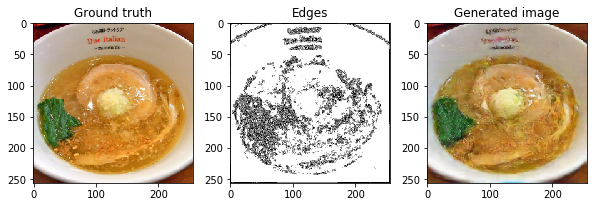

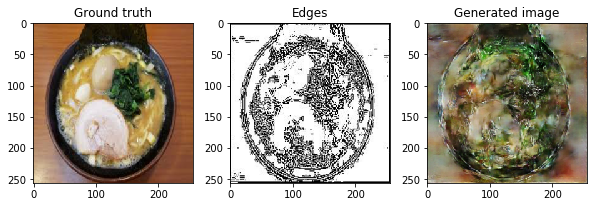

In [10]:
'''
Training_data
'''
file_list = os.listdir('/home/ec2-user/SageMaker/efs/food101/food-101/images/ramen/')
index = np.random.choice(len(file_list))

edge_image = read_image(os.path.join('/home/ec2-user/SageMaker/efs/food101/food-101/images/ramen_edge', file_list[index])).asnumpy()

result = predictor.predict(edge_image)

gt_image =  read_image(os.path.join('/home/ec2-user/SageMaker/efs/food101/food-101/images/ramen/', file_list[index])).asnumpy()
gt_image = np.squeeze(gt_image, axis=0).transpose([1,2,0])
gt_image = (gt_image + 1)*127.5
gt_image = gt_image.astype(int)

edge_image = np.squeeze(edge_image, axis=0).transpose([1,2,0])
edge_image = (edge_image + 1)*127.5
edge_image = edge_image.astype(int)

gen_image = (np.array(result)+1)*127.5
gen_image = gen_image.astype(int).transpose([1,2,0])

images = [gt_image, edge_image, gen_image]
labels = ['Ground truth', 'Edges', 'Generated image']

fig0 = plt.figure()
fig0.set_size_inches(10,10)
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    
'''
Test_data
'''

file_list = os.listdir('./test_edge')
index = np.random.choice(len(file_list))

edge_image = read_image(os.path.join('./test_edge', file_list[index])).asnumpy()

result = predictor.predict(edge_image)

gt_image =  read_image(os.path.join('./test', file_list[index])).asnumpy()
gt_image = np.squeeze(gt_image, axis=0).transpose([1,2,0])
gt_image = (gt_image + 1)*127.5
gt_image = gt_image.astype(int)

edge_image = np.squeeze(edge_image, axis=0).transpose([1,2,0])
edge_image = (edge_image + 1)*127.5
edge_image = edge_image.astype(int)

gen_image = (np.array(result)+1)*127.5
gen_image = gen_image.astype(int).transpose([1,2,0])

images = [gt_image, edge_image, gen_image]
labels = ['Ground truth', 'Edges', 'Generated image']

fig1 = plt.figure()
fig1.set_size_inches(10,10)
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])